# FFI analysis -- for zero points

Michael Gully-Santiago  & Natalie Gosnell
April 11, 2019

The goal of this notebook is to get zero points for the M67 K2 campaigns, so we can register their relative fluxes.  We will use the Full Frame Images (FFIs).

In [1]:
import numpy as np
import sep
import pandas as pd
import lightkurve as lk
import fitsio

lk.__version__, sep.__version__, fitsio.__version__, np.__version__, pd.__version__

('1.4.dev', '1.0.3', '1.0.5', '1.16.4', '0.25.0')

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

I wrote some custom tools to work with the driftscan FFIs.

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../code/"))
import ffi_tools

## Get the C5 FFI

In [4]:
c5_ffi_fn = '/Volumes/Truro/ffi/ktwo2015127093352-c05_ffi-cal.fits'
c16_ffi_fn = '/Volumes/Truro/ffi/ktwo2017344214411-c16_ffi-cal.fits'
c18_ffi_fn = '/Volumes/Truro/ffi/ktwo2018143080022-c18_ffi-cal.fits'

In [5]:
ffi_ext_dict = {18:13, 16:52, 5:13}

In [6]:
# read image into standard 2-d numpy array
data, hdr = fitsio.read(c5_ffi_fn, ext=ffi_ext_dict[5], header=True)

Trim the edges, which have dark and smear rows.

In [7]:
data = ffi_tools.preprocess_dFFI(data) 

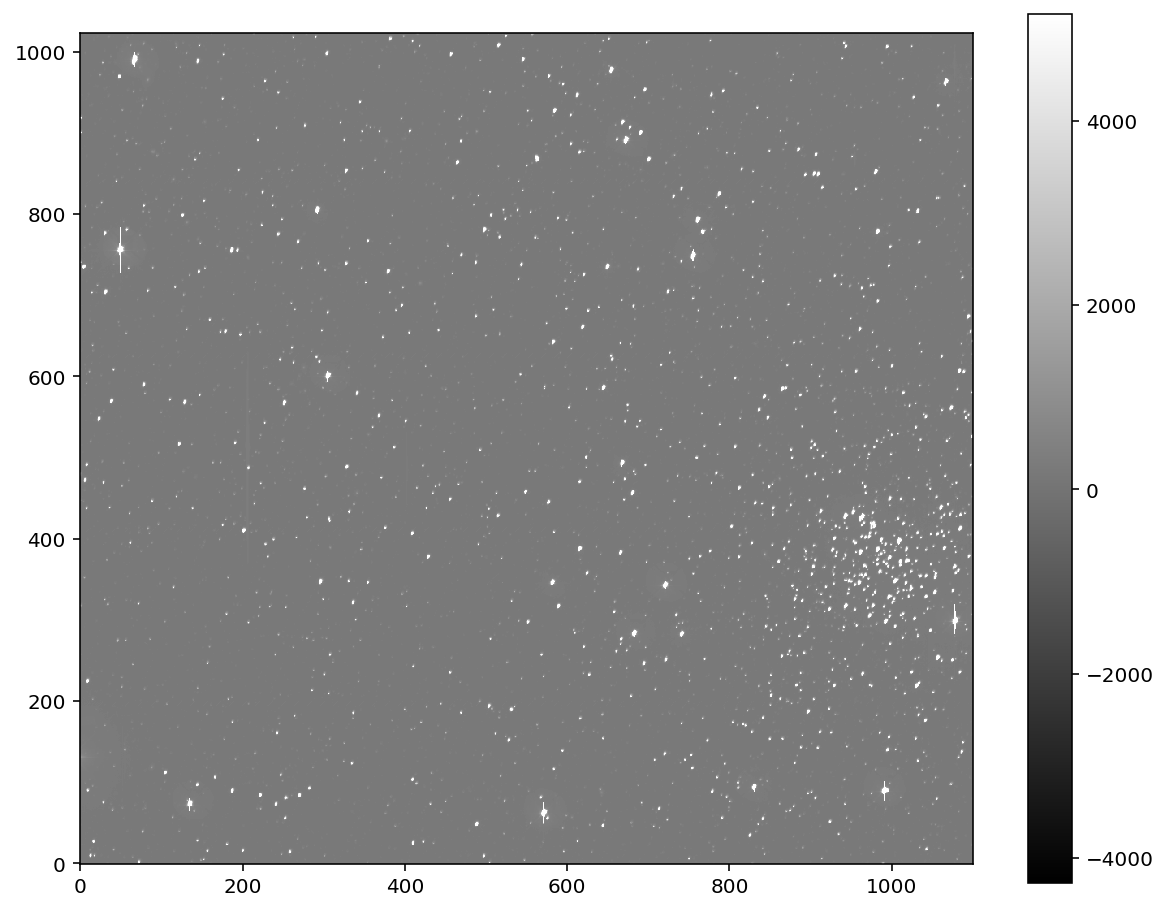

In [8]:
ffi_tools.quick_plot(data)

Look at all the stars!  Let's background subtract.

In [9]:
data_sub, bkg = ffi_tools.background_subtract(data, return_bkg=True)

Mask the brightest quarter of pixels.

## Object detection

We will need a kernel for object detection.  Let's find any isolated bright unsaturated star.

In [10]:
kernel = data_sub[599:606,644:651] # Only works for campaign 18.
kernel = kernel-kernel.min()
kernel = kernel/kernel.sum()

In [11]:
#ffi_tools.plot_kernel(kernel)

OK that's a candidate kernel.

# Object detection

In [12]:
from matplotlib.patches import Ellipse

In [13]:
objects = sep.extract(data_sub, 8.0, filter_kernel=None,  err=bkg.globalrms)
len(objects)

3994

We found thousands of point sources.

In [14]:
angle_degrees = objects['theta'] * 180. / np.pi

In [15]:
twisty = (angle_degrees > -60) & (angle_degrees < 40) & ( objects['a']/objects['b'] > 1.3)

In [16]:
poor_fits = ( (objects['a'] > 2.0) |
              (objects['flux'] > 1e6) |
              (objects['flag'] > 0))

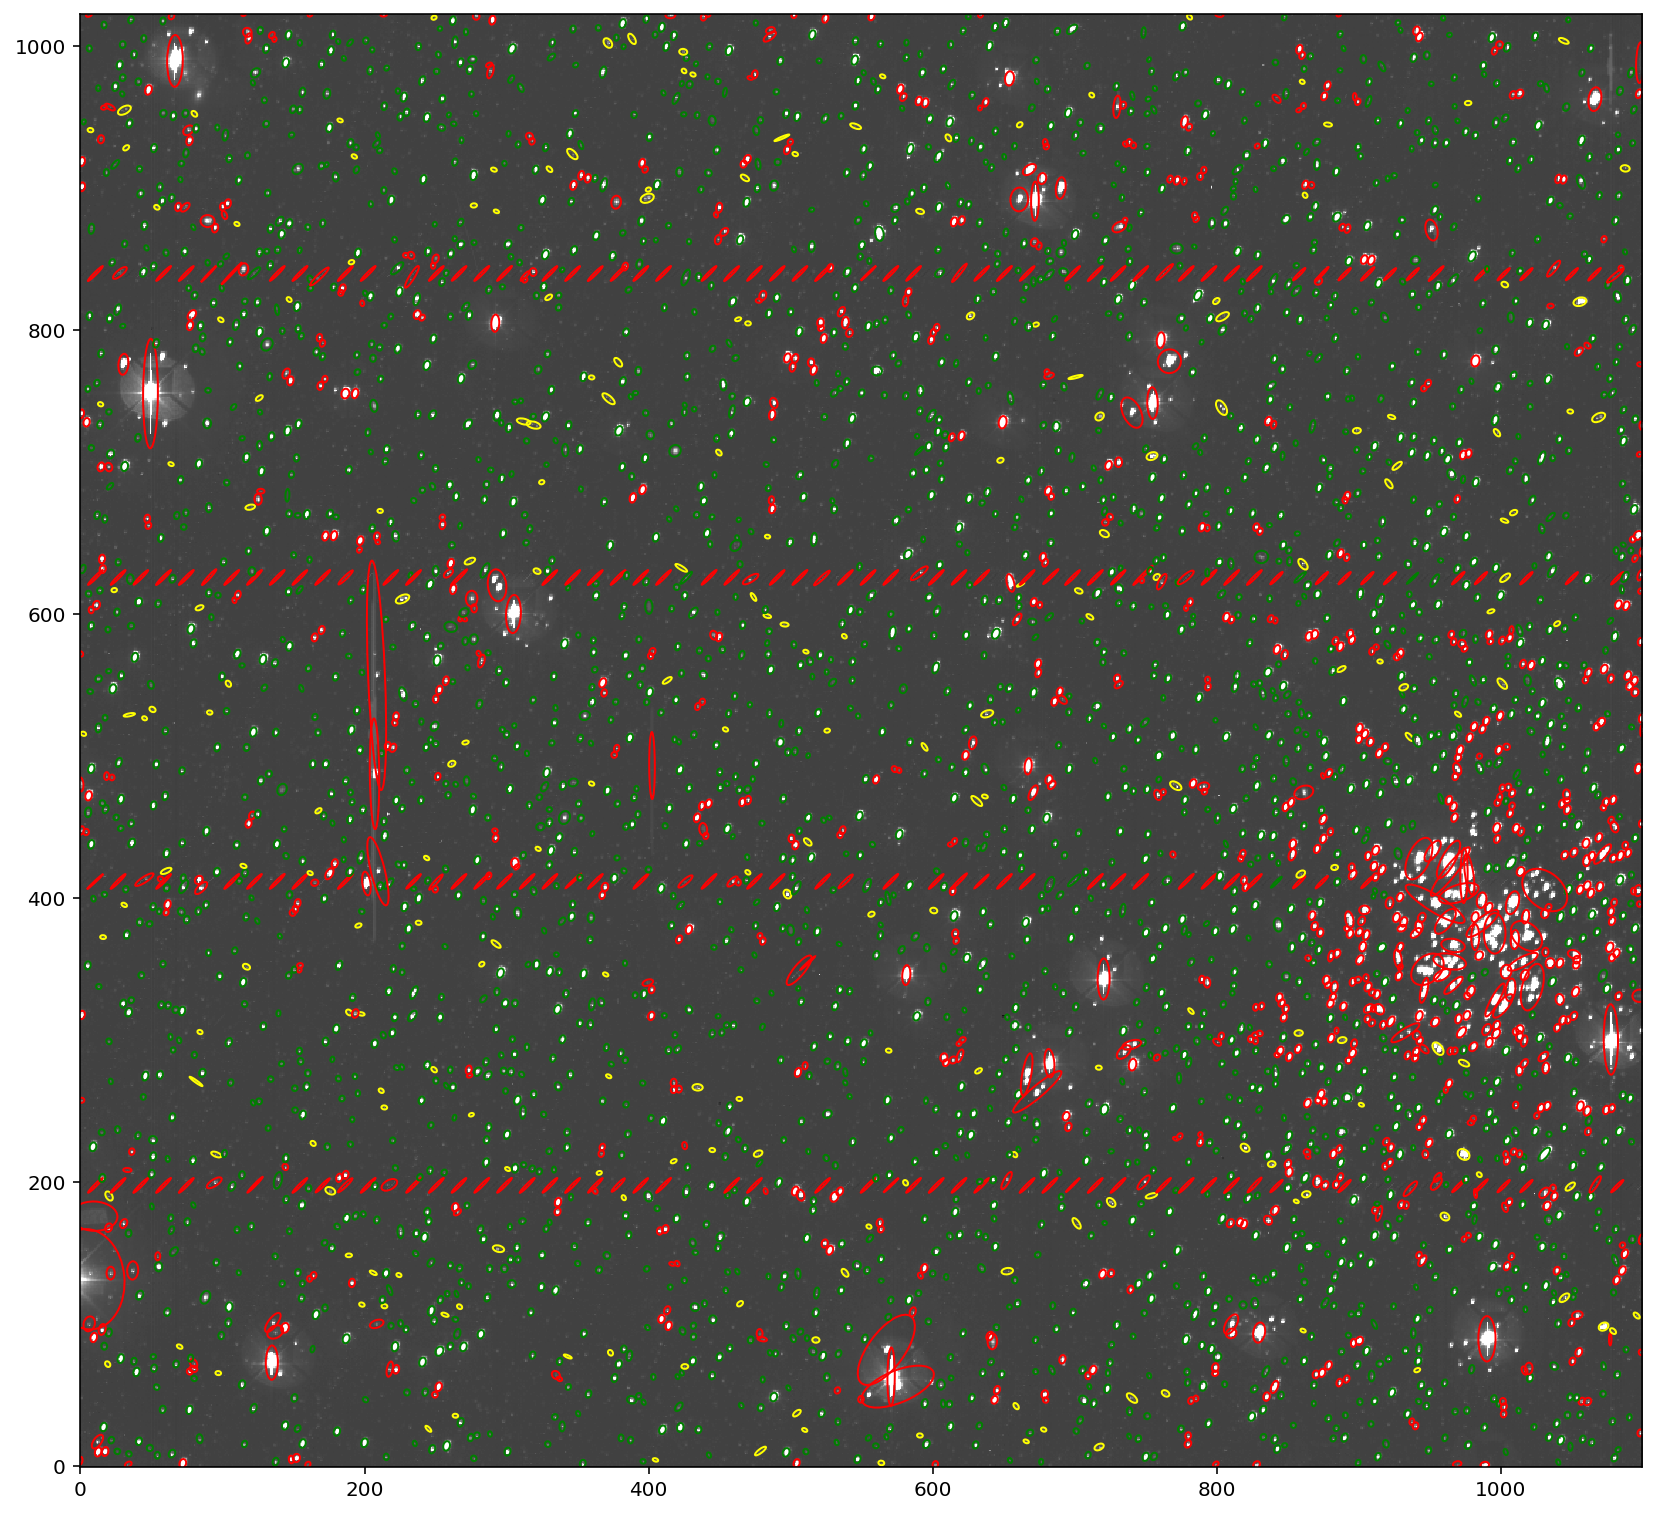

In [17]:
# plot background-subtracted image
fig, ax = plt.subplots(figsize=(14,14))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=-s/20, vmax=m+s/10, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    if poor_fits[i]:
        color = 'red'
    elif twisty[i]:
        color = 'yellow'
    else:
        color = 'green'
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=angle_degrees[i])
    e.set_facecolor('none')
    e.set_edgecolor(color)
    ax.add_artist(e)

One problem is that the source extractor cannot identify sources in M67 because it's so crowded!  This stinks, since the whole point is to calibrate one source in M67!  
We'll come back to that.

In [18]:
faint_objects = objects[~poor_fits & ~twisty]

In [19]:
n_faint = len(faint_objects)
n_faint

2689

In [20]:
df = pd.DataFrame(faint_objects)
df.head()

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
0,24.184298,13,13,352,355,1,4,353.616023,1.719493,0.475623,...,-0.447432,2543.623535,2543.623535,636.738037,636.738037,354,1,354,1,0
1,24.184298,7,7,395,397,2,4,396.052505,3.206893,0.372528,...,0.327671,443.740356,443.740356,201.152679,201.152679,396,3,396,3,0
2,24.184298,6,6,676,677,2,4,676.347610,2.858120,0.226777,...,-0.192598,340.837036,340.837036,118.907013,118.907013,676,3,676,3,0
3,24.184298,8,8,899,901,1,4,899.519695,2.130281,0.332472,...,-0.892270,687.268860,687.268860,221.709412,221.709412,899,2,899,2,0
4,24.184298,5,5,1040,1041,2,4,1040.429352,2.650401,0.245009,...,2.206060,313.532104,313.532104,87.672699,87.672699,1040,3,1040,3,0


Let's use the WCS to assign an RA and Dec to each source.  Then we can match across the three campaigns, and see how the fluxes scale between each one.  

In [21]:
from astropy.wcs import WCS

In [22]:
wcs_hdr = WCS(header=hdr)

Important! You need to add back in the $x_0$ and $y_0$ corner offsets for the WCS to be accurate!!

In [23]:
x0_offset, y0_offset = 12, 19
xy_in = np.vstack((df.x.values+x0_offset, df.y.values+y0_offset)).T

In [24]:
ra_decs = wcs_hdr.all_pix2world(xy_in, 0)
df['ra'], df['dec'] = ra_decs[:,0], ra_decs[:,1]

### Cross match with Gaia

It might be helpful to compare the Gaia fluxes as an external calibration source.

In [25]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from astropy import units as u
Vizier.ROW_LIMIT = 50000

In [26]:
c1 = SkyCoord(df['ra'].mean(), df['dec'].mean(), unit=(u.deg, u.deg))

Query Gaia DR2 programmatically.

In [27]:
result = Vizier.query_region(c1, catalog=["I/345/gaia2"], radius=3000.0*u.arcsec)["I/345/gaia2"]

In [28]:
bright_mask = (result['Gmag'] < 20.0).data
result = result[bright_mask]
radecs_gaia = np.vstack([result['RA_ICRS'].data.data, result['DE_ICRS'].data.data]).T

In [29]:
df_gaia = result.to_pandas()

Do the cross matching.

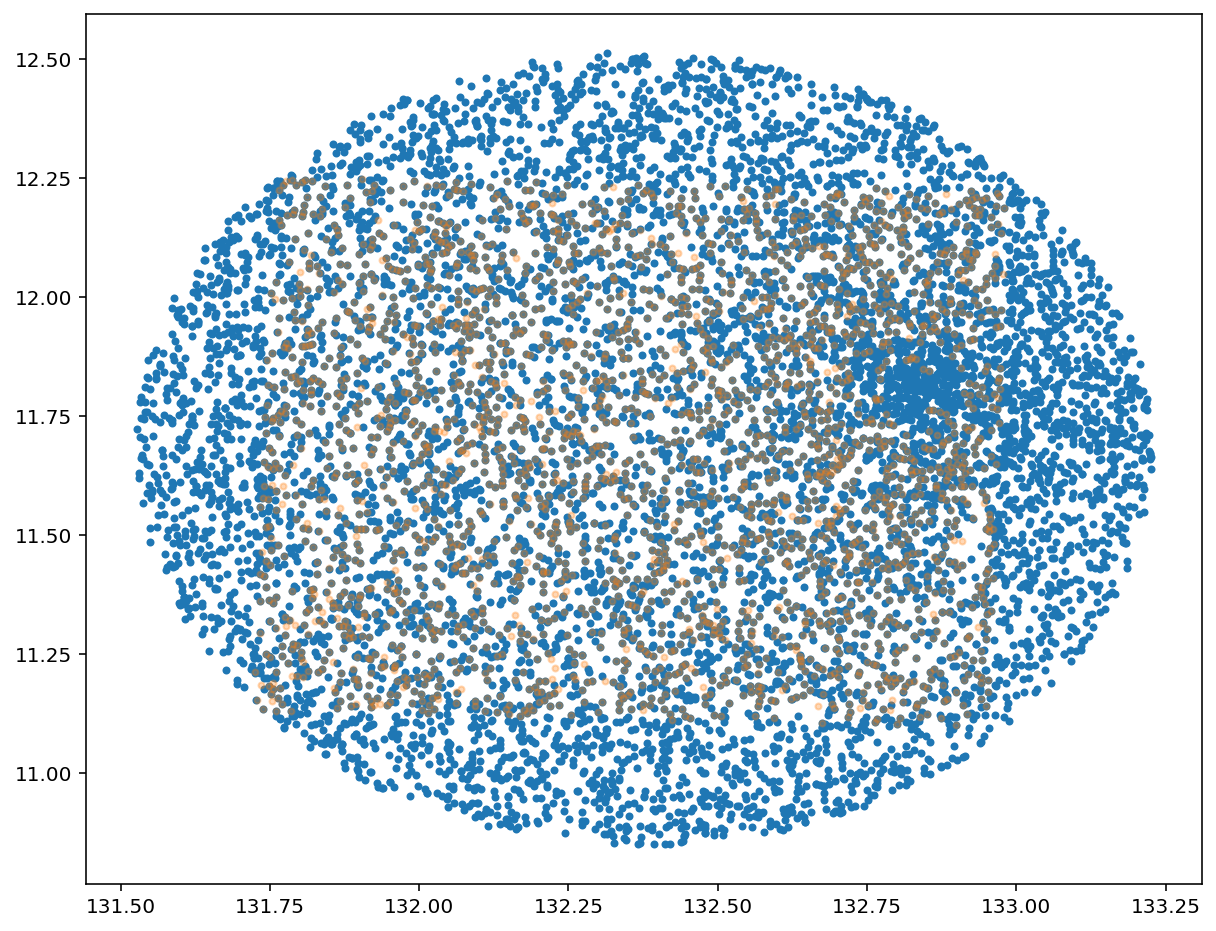

In [30]:
plt.plot(radecs_gaia[:,0], radecs_gaia[:,1], '.')
plt.plot(ra_decs[:,0], ra_decs[:,1], '.', alpha=0.3);

Perfect!  Match the Kepler derived RA, Decs to the Gaia catalog.

In [31]:
c = SkyCoord(ra=ra_decs[:,0]*u.degree, dec=ra_decs[:,1]*u.degree)
catalog = SkyCoord(ra=radecs_gaia[:, 0]*u.degree, dec=radecs_gaia[:, 1]*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

In [32]:
df['idx'] = idx
df['d2d'] = d2d.to(u.arcsecond).value

In [33]:
df_merge = pd.merge(df, df_gaia, how='left', left_on='idx', right_index=True)

Eliminate bad matches separated by more than 5 arcseconds.

In [34]:
df_merge = df_merge[df_merge.d2d<5]

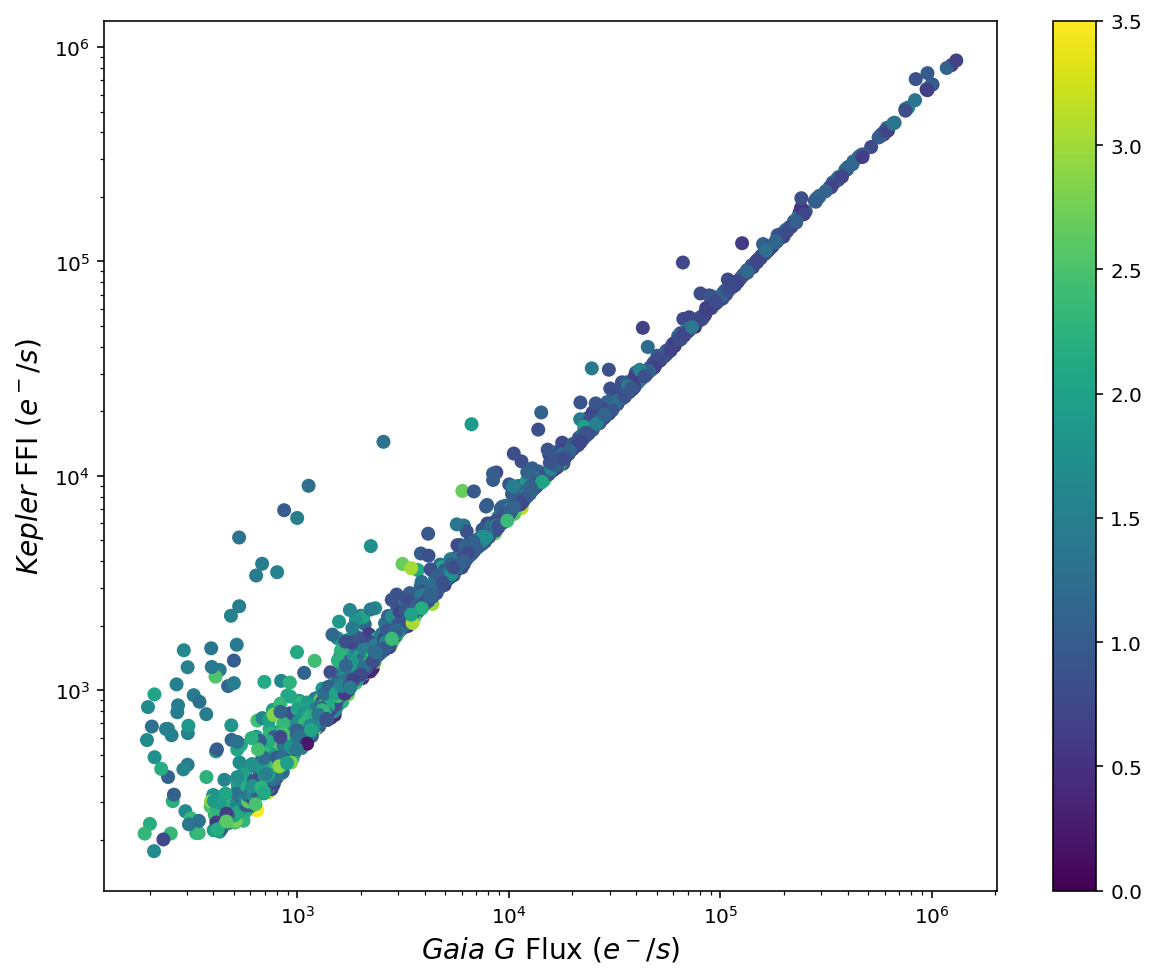

In [35]:
sc = plt.scatter(df_merge.FG, df_merge.flux, c=df_merge['BP-RP'], vmin=0, vmax=3.5)
cb = plt.colorbar(sc)
plt.xlabel('$Gaia$ $G$ Flux ($e^-/s$)', fontsize=14)
plt.ylabel('$Kepler$ FFI ($e^-/s$)', fontsize=14)
plt.xscale('log')
plt.yscale('log')

Great!  Everything checks out!

The next step will be to repeat this process for all campaigns, and then calibrate the stars.  We'll do that in the next notebook!